In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.compose import ColumnTransformer
import numpy as np
from catboost import CatBoostClassifier, Pool
import pickle

In [21]:
#загружаем трэйн
df_orders_flat = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\18_12\df_orders_flat.parquet')

In [45]:
df_orders_flat_out = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\18_12\df_orders_flat_out.parquet')

In [22]:
df_orders_flat

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,user_1,female,3,1.0,1.634292e+09,None,NaN,None,NaN
1,user_1,female,3,2.0,1.639827e+09,None,NaN,None,NaN
2,user_1,female,3,2.0,1.639828e+09,None,NaN,None,NaN
3,user_2,female,11,NaN,NaN,None,NaN,None,NaN
4,user_5,female,35,39.0,1.644809e+09,None,NaN,None,NaN
...,...,...,...,...,...,...,...,...,...
2122025,user_127751,male,11,16.0,1.648560e+09,item_5409133,1.0,"[90590, 12327586, 90579, 198118]",1446.0
2122026,user_127751,male,11,16.0,1.649580e+09,item_56817,1.0,"[14333188, 10604398, 91009]",3503.0
2122027,user_127752,male,13,147.0,1.612968e+09,None,NaN,None,NaN
2122028,user_127752,male,13,147.0,1.612969e+09,None,NaN,None,NaN


In [282]:

#дропаем лишние столбцы (если они есть)
#columns_to_drop = ['median_length',  'average_common_categories', 'average_categories']
#df_orders_flat = df_orders_flat.drop(columns=columns_to_drop)

In [23]:
#загружаем валидацию
val = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\18_12\val_test.parquet')

In [46]:
val_out = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\18_12\val_test_out.parquet')

In [24]:
val

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,user_127756,female,8,407.0,1.697126e+09,item_676374,NaN,None,NaN
1,user_127758,female,50,149.0,1.658741e+09,item_3868047,NaN,"[13243353, 91182, 91157, 90509]",1844.0
2,user_127758,female,50,149.0,1.658741e+09,item_43151,NaN,"[7693914, 91172, 90509]",4690.0
3,user_127758,female,50,149.0,1.658741e+09,item_2265109,NaN,"[91174, 91172, 90509]",17524.0
4,user_127758,female,50,149.0,1.668072e+09,item_106819,NaN,"[13334231, 91172, 90509]",55089.0
...,...,...,...,...,...,...,...,...,...
481824,user_155199,male,7,21.0,1.697884e+09,None,NaN,None,NaN
481825,user_155199,male,7,21.0,1.697888e+09,None,NaN,None,NaN
481826,user_155201,male,27,218.0,1.684708e+09,None,NaN,None,NaN
481827,user_155201,male,27,218.0,1.684708e+09,None,NaN,None,NaN


In [25]:

def preprocess_dataframe(df):
    # Удаление выбранных столбцов
    #columns_to_drop = ['num_categories',	'num_common_categories',  'male_cat',	'female_cat']
    #columns_to_drop = ['created-at']
    #df = df.drop(columns=columns_to_drop)

    # Сбрасываем индексы, чтобы избежать дубликатов после explode
    df = df.reset_index(drop=True)
    #делаем explode для general-category-path   
    df = df.explode('general-category-path')
    
    
    df['id'] = df['id'].str.replace('item_', '')
    # Замена NaN на 0
    df = df.fillna(0)

    # Преобразование столбцов в int16
    int16_columns = ['site-id', 'count']
    df[int16_columns] = df[int16_columns].astype('int16')

    # Удаление слова 'user' в каждой строке столбца 'user_id'
    df['user_id'] = df['user_id'].str.replace('user_', '')

    # Преобразование столбца 'user_id' в int32
    df['user_id'] = df['user_id'].astype('int32')
    df['general-category-path'] = df['general-category-path'].astype('int32')
    
    df['brand-id'] = df['brand-id'].astype('int32')

       # Обработка столбца 'id'
    df['id'] = df['id'].astype('int32')
    

    # Преобразование 'target' в числовое представление
    df['target'] = df['target'].map({'male': 0, 'female': 1})

    return df




In [26]:

df_orders_flat = preprocess_dataframe(df_orders_flat)

In [47]:
df_orders_flat_out = preprocess_dataframe(df_orders_flat_out)

In [27]:
val = preprocess_dataframe(val)

In [48]:
val_out = preprocess_dataframe(val_out)

In [51]:
val_out

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127787,1,130,48,1.655794e+09,2498033,1,5151017,1926679
0,127787,1,130,48,1.655794e+09,2498033,1,7774309,1926679
0,127787,1,130,48,1.655794e+09,2498033,1,90666,1926679
1,127787,1,130,48,1.655794e+09,2498034,1,91284,1926679
1,127787,1,130,48,1.655794e+09,2498034,1,7774309,1926679
...,...,...,...,...,...,...,...,...,...
333627,155129,0,69,102,1.694870e+09,6168578,1,0,0
333628,155129,0,69,10,1.675796e+09,0,0,0,0
333629,155129,0,69,209,1.544362e+09,6168579,1,15726412,0
333629,155129,0,69,209,1.544362e+09,6168579,1,91349,0


In [49]:

df_orders_flat_out

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,21,1,116,391,1.683183e+09,1642,34,0,0
1,21,1,116,391,1.683283e+09,1642,34,0,0
2,21,1,116,391,1.686145e+09,1643,40,0,0
3,21,1,116,391,1.686592e+09,1642,27,0,0
4,21,1,116,391,1.686592e+09,1644,2,0,0
...,...,...,...,...,...,...,...,...,...
1348609,127743,0,80,112,1.682406e+09,1660616,0,0,0
1348610,127743,0,80,112,1.682520e+09,3850967,0,0,0
1348611,127743,0,80,112,1.682520e+09,2811078,0,0,0
1348612,127743,0,80,112,1.682520e+09,1248095,0,0,0


In [29]:
val

,user_id,target,length,site-id,created-at,id,count,general-category-path,brand-id
0,127756,1,8,407,1.697126e+09,676374,0,0,0
1,127758,1,50,149,1.658741e+09,3868047,0,13243353,1844
1,127758,1,50,149,1.658741e+09,3868047,0,91182,1844
1,127758,1,50,149,1.658741e+09,3868047,0,91157,1844
1,127758,1,50,149,1.658741e+09,3868047,0,90509,1844
...,...,...,...,...,...,...,...,...,...
481824,155199,0,7,21,1.697884e+09,0,0,0,0
481825,155199,0,7,21,1.697888e+09,0,0,0,0
481826,155201,0,27,218,1.684708e+09,0,0,0,0
481827,155201,0,27,218,1.684708e+09,0,0,0,0


In [159]:
# Разделение данных на train и test
X_train = df_orders_flat.drop(columns=['target'])
y_train = df_orders_flat['target']
X_test = val.drop(columns=['target'])
y_test = val['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Разделение данных на train и test
X_train_out = df_orders_flat_out.drop(columns=['target'])
y_train_out = df_orders_flat_out['target']
X_test_out = val_out.drop(columns=['target'])
y_test_out = val_out['target']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127756,8,407,1.697126e+09,676374,0,0,0
1,127758,50,149,1.658741e+09,3868047,0,13243353,1844
1,127758,50,149,1.658741e+09,3868047,0,91182,1844
1,127758,50,149,1.658741e+09,3868047,0,91157,1844
1,127758,50,149,1.658741e+09,3868047,0,90509,1844
...,...,...,...,...,...,...,...,...
481824,155199,7,21,1.697884e+09,0,0,0,0
481825,155199,7,21,1.697888e+09,0,0,0,0
481826,155201,27,218,1.684708e+09,0,0,0,0
481827,155201,27,218,1.684708e+09,0,0,0,0


c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-error:0.26094	train-error:0.27049
[1]	test-error:0.26094	train-error:0.27049
[2]	test-error:0.25854	train-error:0.26831
[3]	test-error:0.25854	train-error:0.26831
[4]	test-error:0.25748	train-error:0.26714
[5]	test-error:0.25308	train-error:0.26194
[6]	test-error:0.25042	train-error:0.25846
[7]	test-error:0.24787	train-error:0.25427
[8]	test-error:0.24486	train-error:0.25003
[9]	test-error:0.24452	train-error:0.25014
[10]	test-error:0.24374	train-error:0.24983
[11]	test-error:0.24248	train-error:0.24801
[12]	test-error:0.24159	train-error:0.24690
[13]	test-error:0.24125	train-error:0.24638
[14]	test-error:0.24202	train-error:0.24665
[15]	test-error:0.24100	train-error:0.24610
[16]	test-error:0.23982	train-error:0.24464
[17]	test-error:0.23803	train-error:0.24310
[18]	test-error:0.23776	train-error:0.24285
[19]	test-error:0.23298	train-error:0.23842
[20]	test-error:0.23327	train-error:0.23860
[21]	test-error:0.23234	train-error:0.23815
[22]	test-error:0.23021	train-error:0.2364

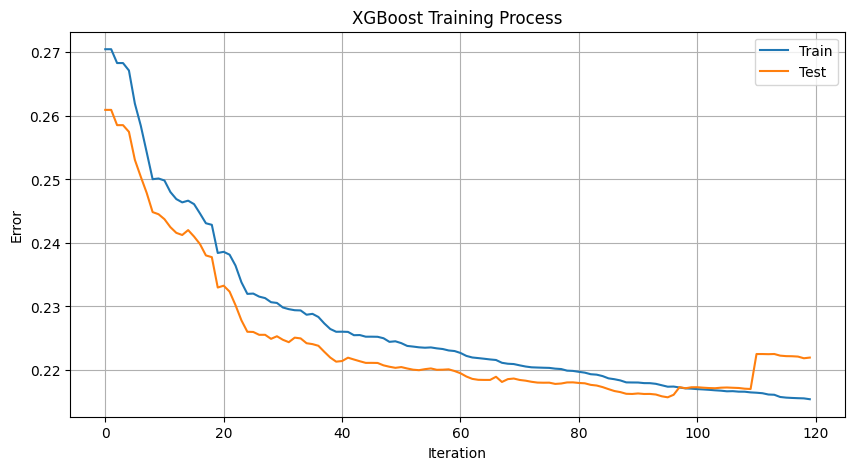

In [32]:

# Создание DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Определение параметров
param = {
    'max_depth': 3,  # глубина деревьев
    'eta': 0.3,  # шаг обучения
    'objective': 'binary:logistic',  # тип задачи
    'eval_metric': 'error'  # метрика оценки
}


# Обучение модели
num_round = 120 #эпохи
evals = [(dtest, 'test'), (dtrain, 'train')]
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=10, evals_result=evals_result)

# Предсказание на тестовом наборе данных
preds = bst.predict(dtest)
predictions = [round(value) for value in preds]

# Вычисление точности
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

plt.figure(figsize=(10,5))
plt.plot(evals_result['train']['error'], label='Train')
plt.plot(evals_result['test']['error'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('XGBoost Training Process')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
X_test

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127756,8,407,1.697126e+09,676374,0,0,0
1,127758,50,149,1.658741e+09,3868047,0,13243353,1844
1,127758,50,149,1.658741e+09,3868047,0,91182,1844
1,127758,50,149,1.658741e+09,3868047,0,91157,1844
1,127758,50,149,1.658741e+09,3868047,0,90509,1844
...,...,...,...,...,...,...,...,...
481824,155199,7,21,1.697884e+09,0,0,0,0
481825,155199,7,21,1.697888e+09,0,0,0,0
481826,155201,27,218,1.684708e+09,0,0,0,0
481827,155201,27,218,1.684708e+09,0,0,0,0


In [62]:
X_test_out

,user_id,length,site-id,created-at,id,count,general-category-path,brand-id
0,127787,130,48,1.655794e+09,2498033,1,5151017,1926679
0,127787,130,48,1.655794e+09,2498033,1,7774309,1926679
0,127787,130,48,1.655794e+09,2498033,1,90666,1926679
1,127787,130,48,1.655794e+09,2498034,1,91284,1926679
1,127787,130,48,1.655794e+09,2498034,1,7774309,1926679
...,...,...,...,...,...,...,...,...
333627,155129,69,102,1.694870e+09,6168578,1,0,0
333628,155129,69,10,1.675796e+09,0,0,0,0
333629,155129,69,209,1.544362e+09,6168579,1,15726412,0
333629,155129,69,209,1.544362e+09,6168579,1,91349,0


In [160]:

#обучим датасеты без выбросов

# Создание пула данных для CatBoost
train_pool = Pool(X_train, y_train, group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'] )
test_pool = Pool(X_test, y_test, group_id=X_test['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'])
#group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
#group_id=X_test['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
# Определение параметров
params = {
    'iterations': 150,
    'depth': 3,
    'learning_rate':0.45,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    
    'random_state': 42
}

# Создание и обучение модели
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=test_pool, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7784846	test: 0.7286130	best: 0.7286130 (0)	total: 2.15s	remaining: 5m 19s
10:	learn: 0.8618692	test: 0.7322153	best: 0.7322153 (10)	total: 17.7s	remaining: 3m 43s
20:	learn: 0.8635586	test: 0.7334231	best: 0.7334231 (20)	total: 29.2s	remaining: 2m 59s
30:	learn: 0.8640899	test: 0.7336534	best: 0.7337364 (29)	total: 41s	remaining: 2m 37s
40:	learn: 0.8643399	test: 0.7343231	best: 0.7343231 (40)	total: 53.3s	remaining: 2m 21s
50:	learn: 0.8658088	test: 0.7347002	best: 0.7347335 (46)	total: 1m 4s	remaining: 2m 5s
60:	learn: 0.8671576	test: 0.7344999	best: 0.7347335 (46)	total: 1m 16s	remaining: 1m 52s
70:	learn: 0.8682140	test: 0.7343700	best: 0.7347335 (46)	total: 1m 28s	remaining: 1m 38s
80:	learn: 0.8689600	test: 0.7343067	best: 0.7347335 (46)	total: 1m 40s	remaining: 1m 25s
90:	learn: 0.8697362	test: 0.7343962	best: 0.7347335 (46)	total: 1m 53s	remaining: 1m 13s
100:	learn: 0.8700231	test: 0.7346473	best: 0.7347335 (46)	total: 2m 4s	remaining: 1m
110:	learn: 0.8702775	tes

In [124]:
#обучим датасеты с выбросами
# Создание пула данных для CatBoost
train_pool_out = Pool(X_train_out, y_train_out, group_id=X_train_out['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id'])

test_pool_out = Pool(X_test_out,  y_test_out, group_id=X_test_out['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id'] )
#group_id=X_train['user_id'],  cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
#group_id=X_test['user_id'], cat_features=['brand-id', 'site-id', 'general-category-path', 'id']
# Определение параметров
params_out = {
    'iterations': 40,
    'depth': 3,
    'learning_rate':0.45,
    'l2_leaf_reg': 5,
    'loss_function': 'Logloss',
    'eval_metric': 'Accuracy',
    'verbose': 10,
    
    'random_state': 42
}

# Создание и обучение модели
model_out = CatBoostClassifier(**params_out)
model_out.fit(train_pool_out, eval_set=test_pool_out, plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7600535	test: 0.7601644	best: 0.7601644 (0)	total: 1.28s	remaining: 49.9s
10:	learn: 0.8644684	test: 0.7504238	best: 0.7601644 (0)	total: 10.5s	remaining: 27.7s
20:	learn: 0.8681417	test: 0.7509323	best: 0.7601644 (0)	total: 19.1s	remaining: 17.3s
30:	learn: 0.8715247	test: 0.7520839	best: 0.7601644 (0)	total: 26.8s	remaining: 7.79s
39:	learn: 0.8728269	test: 0.7523207	best: 0.7601644 (0)	total: 33.6s	remaining: 0us

bestTest = 0.7601644321
bestIteration = 0

Shrink model to first 1 iterations.


In [161]:
predictions = model.predict(X_test)
accuracy1 = accuracy_score(y_test, predictions)
predictions = pd.Series(predictions, name='predictions')
print(f'Accuracy Model : {accuracy1}')


Accuracy Model : 0.7347335420802171


In [162]:
result = pd.concat([X_test.reset_index(drop=True), predictions], axis=1, ignore_index=True)

result

,0,1,2,3,4,5,6,7,8
0,127756,8,407,1.697126e+09,676374,0,0,0,1
1,127758,50,149,1.658741e+09,3868047,0,13243353,1844,1
2,127758,50,149,1.658741e+09,3868047,0,91182,1844,1
3,127758,50,149,1.658741e+09,3868047,0,91157,1844,1
4,127758,50,149,1.658741e+09,3868047,0,90509,1844,1
...,...,...,...,...,...,...,...,...,...
1832198,155129,69,102,1.694870e+09,6168578,1,0,0,1
1832199,155129,69,10,1.675796e+09,0,0,0,0,1
1832200,155129,69,209,1.544362e+09,6168579,1,15726412,0,1
1832201,155129,69,209,1.544362e+09,6168579,1,91349,0,1


In [163]:
# Переименовать столбцы
result.columns = ['user_id', 'length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id', 'predictions']

# Удалить лишние столбцы
result.drop(columns=['length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id'], inplace=True)



In [164]:

# Сгруппировать по user_id

grouped_df = result.groupby('user_id')['predictions'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='prediction')
#grouped_df = result.groupby('user_id')['predictions'].mode().reset_index()

# Округлить результат
#grouped_df['predictions'] = grouped_df['predictions']).astype(int)
grouped_df

,user_id,prediction
0,127756,1
1,127757,0
2,127758,1
3,127759,1
4,127760,0
...,...,...
27442,155198,1
27443,155199,0
27444,155200,1
27445,155201,1


In [129]:
predictions_out = model_out.predict(X_test_out)
accuracy2 = accuracy_score(y_test_out, predictions_out)
predictions_out = pd.Series(predictions_out, name='predictions')
print(f'Accuracy Model : {accuracy2}')

Accuracy Model : 0.7601644320572639


In [130]:
result_out = pd.concat([X_test_out.reset_index(drop=True), predictions_out], axis=1, ignore_index=True)
# Переименовать столбцы
result_out.columns = ['user_id', 'length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id', 'predictions']

# Удалить лишние столбцы
result_out.drop(columns=['length', 'site-id', 'created-at', 'id', 'count', 'general-category-path', 'brand-id'], inplace=True)


In [153]:

grouped_out_df = result_out.groupby('user_id')['predictions'].apply(lambda x: x.value_counts().idxmax()).reset_index(name='prediction')
#grouped_out_df = result_out.groupby('user_id')['predictions'].mean().reset_index()

# Округлить результат
#grouped_out_df['predictions'] = np.round(grouped_out_df['predictions']).astype(int)
grouped_out_df

,user_id,prediction
0,127785,0
1,127787,1
2,127788,0
3,127802,1
4,127804,1
...,...,...
1814,155129,0
1815,155136,1
1816,155142,1
1817,155153,1


In [154]:
result_union = pd.concat([grouped_df, grouped_out_df], ignore_index=True)
result_union

,user_id,prediction
0,127756,1
1,127757,0
2,127758,1
3,127759,1
4,127760,0
...,...,...
27442,155129,0
27443,155136,1
27444,155142,1
27445,155153,1


In [89]:
#загружаем итоговую валидацию

val_final = pd.read_parquet(r'C:\Users\Alex\Desktop\data_science\мфти\хакатон\flockery\18_12\val_final.parquet')

In [167]:
final_df = pd.merge(result_union, val_final, how='left', on='user_id')
final_df

,user_id,prediction,target
0,127756,1,1
1,127757,0,0
2,127758,1,1
3,127759,1,1
4,127760,0,1
...,...,...,...
27442,155129,0,0
27443,155136,1,1
27444,155142,1,1
27445,155153,1,1


In [168]:
# Рассчитать accuracy
accuracy = accuracy_score(final_df['target'], final_df['prediction'])

print(f'Accuracy: {accuracy}')

Accuracy: 0.7062338324771378


In [157]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,id,49.453305
1,length,33.295237
2,site-id,11.324744
3,general-category-path,3.574200
4,brand-id,1.858236
5,created-at,0.408498
6,user_id,0.069631
7,count,0.016149


In [44]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,id,49.453305
1,length,33.295237
2,site-id,11.324744
3,general-category-path,3.574200
4,brand-id,1.858236
5,created-at,0.408498
6,user_id,0.069631
7,count,0.016149


c:\Users\Alex\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	test-error:0.00000	train-error:0.00000
[1]	test-error:0.00000	train-error:0.00000
[2]	test-error:0.00000	train-error:0.00000
[3]	test-error:0.00000	train-error:0.00000
[4]	test-error:0.00000	train-error:0.00000
[5]	test-error:0.00000	train-error:0.00000
[6]	test-error:0.00000	train-error:0.00000
[7]	test-error:0.00000	train-error:0.00000
[8]	test-error:0.00000	train-error:0.00000
[9]	test-error:0.00000	train-error:0.00000
[10]	test-error:0.00000	train-error:0.00000


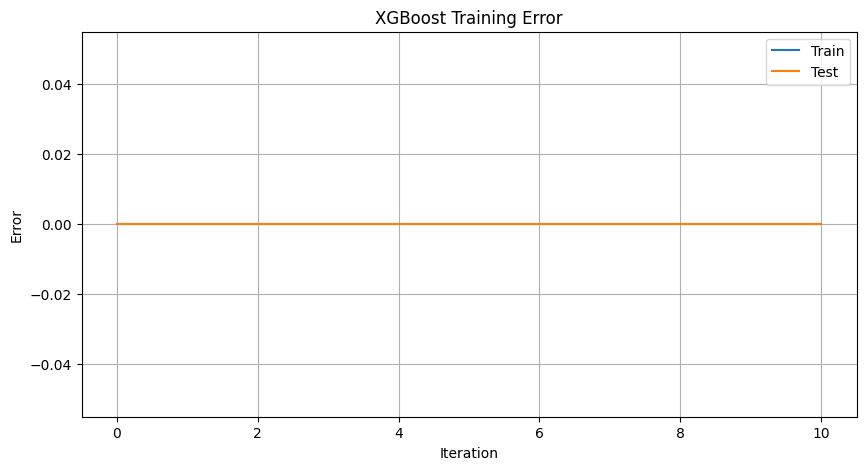

In [68]:


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование данных в DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Определение параметров
param = {
    'max_depth': 3,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

# Обучение модели
num_round = 20

# Обучение модели
evals_result = {}
bst = xgb.train(param, dtrain, num_round, evals, early_stopping_rounds=10, evals_result=evals_result)

# Визуализация процесса обучения
plt.figure(figsize=(10,5))
plt.plot(evals_result['train']['error'], label='Train')
plt.plot(evals_result['test']['error'], label='Test')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('XGBoost Training Error')
plt.legend()
plt.grid(True)
plt.show()
